In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation
import pandas as pd


In [3]:
data = fetch_20newsgroups()
print(data.target_names)
#fetching with train/test split-
x_test = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='test')
x_train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='train')
y_test = x_test.target
test_target_names = x_test.target_names
train_target_names = x_train.target_names
y_train = x_train.target



x_test = x_test.data
x_train = x_train.data
#fixing dimensions (not working)
# x = np.array(x)
# y= np.array(y)
# x = x[:,np.newaxis]
# y = y[:,np.newaxis]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


[480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


([<matplotlib.axis.XTick at 0x1df70802d70>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

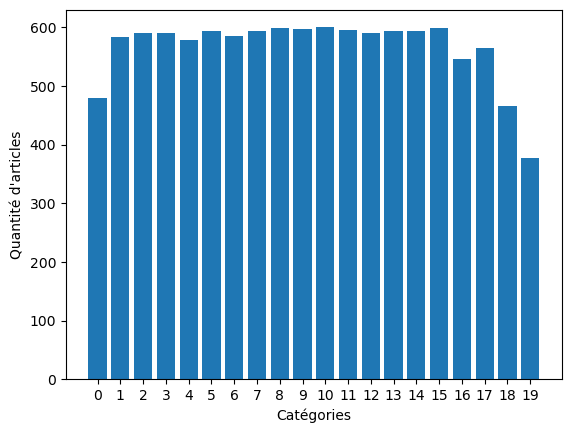

In [4]:
unique_labels = np.unique(data.target, return_counts=True)
print(unique_labels[1])
plt.bar(x=unique_labels[0], height=unique_labels[1])
plt.xlabel('Catégories')
plt.ylabel("Quantité d'articles")
plt.xticks(ticks=unique_labels[0])

In [5]:
cluster_number = len(np.unique(data.target))
cluster_number

20

In [6]:
# shamelessly stealing Adrien's nice function for clustering benchmark, with some twist:, 

def bench_clust(estimator, data, name, ground_truth = None):
    estimator.fit_transform(data)
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]
    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            #where ground truth is provided
            score = getattr(metrics, s)(ground_truth, estimator.labels_)
        elif ground_truth is not None:
            score = getattr(metrics, s)(data, estimator.labels_)
        else: 
            continue

        results.append(score)
    res = pd.DataFrame([results], columns=scores, index=[str(name)])
    return  res

In [7]:
# Another function for test set supervised metrics
def split_evaluation(estimator, data, name, ground_truth):
    y_hat = estimator.fit_predict(data)
    print(' '+25*'=' + f'{name} Metrics'+25*'=')
    accuracy = metrics.accuracy_score(ground_truth, y_hat)
    print(f' Accuracy : {accuracy=}')
    print('\ n Report : \n')
    report = metrics.classification_report(ground_truth, y_hat, target_names=test_target_names)
    print(report)
    print(50*'=')
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]
    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            #where ground truth is provided
            score = getattr(metrics, s)(ground_truth, y_hat)
        elif ground_truth is not None:
            score = getattr(metrics, s)(data, estimator.labels_)
        else: 
            continue

        results.append(score)
    res = pd.DataFrame([results], columns=scores, index=[str(name)])
    return  res


In [8]:
#building train test split : 
# x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)
# this method seems to be cumbersome to implement in this context, so we'll use the pre-splitted dataset directly

# failed to build a pipeline, it seems to cause a data dimension error that does not occur while working "the handy way", 
# # using CountVectorizer to extract tokens matrix, and kmeans as a model, in a sequence.
vect = CountVectorizer(max_features=10000, stop_words='english')
x_train_vec = vect.fit_transform(x_train)

model1 = KMeans(n_clusters= cluster_number)
#let's give it a try : 
res_train = bench_clust(model1, x_train_vec,'train_countvect and kmeans', y_train)
res_train

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


adjusted_rand_score  adjusted_mutual_info_score  \
train_countvect and kmeans             0.000008                    0.002499   

                            silhouette_score  homogeneity_score  \
train_countvect and kmeans          0.887019           0.003598   

                            completeness_score  v_measure_score  
train_countvect and kmeans            0.164423         0.007043

In [9]:
# using the test set
x_test_vec = vect.fit_transform(x_test)
res_test = split_evaluation(model1, x_test_vec,'test_countvect and kmeans' , y_test)
res_test

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 =========================test_countvect and kmeans Metrics=========================
 Accuracy : accuracy=0.05204460966542751
\ n Report : 

                          precision    recall  f1-score   support

             alt.atheism       0.03      0.00      0.01       319
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.05      0.99      0.10       394
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.00      0.00      0.00       395
            misc.forsale       0.00      0.00      0.00       390
               rec.autos       0.00      0.00      0.00       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.00      0.00      0.00       397
        rec.sport.hockey       1.00      0.00      0.01       399
               sci.crypt       0.00      0.00      0.00       396


adjusted_rand_score  adjusted_mutual_info_score  \
test_countvect and kmeans             0.000027                    0.002181   

                           silhouette_score  homogeneity_score  \
test_countvect and kmeans          0.856177           0.004338   

                           completeness_score  v_measure_score  
test_countvect and kmeans            0.228601         0.008515

In [10]:
#test with tfidf and stop_words

better_vec = TfidfVectorizer(stop_words='english', max_features=1000)
x_train_vec2 = better_vec.fit_transform(x_train)
model2 = KMeans(n_clusters= cluster_number)
#let's give it a try : 
res_train_2 = bench_clust(model2, x_train_vec2, 'train tdidf and kmeans', y_train)
res_train_2

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


adjusted_rand_score  adjusted_mutual_info_score  \
train tdidf and kmeans             0.057733                    0.226522   

                        silhouette_score  homogeneity_score  \
train tdidf and kmeans          0.013588           0.214704   

                        completeness_score  v_measure_score  
train tdidf and kmeans            0.250027         0.231023

In [11]:
#using the test set
x_test_vec2 = better_vec.fit_transform(x_test)
res_test_2 = split_evaluation(model2, x_test_vec2, 'test tdidf and kmeans', y_test)
res_test_2

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 =========================test tdidf and kmeans Metrics=========================
 Accuracy : accuracy=0.04102496016994158
\ n Report : 

                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       319
           comp.graphics       0.03      0.02      0.02       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
   comp.sys.mac.hardware       0.05      0.03      0.04       385
          comp.windows.x       0.02      0.02      0.02       395
            misc.forsale       0.01      0.01      0.01       390
               rec.autos       0.00      0.00      0.00       396
         rec.motorcycles       0.07      0.15      0.09       398
      rec.sport.baseball       0.03      0.02      0.02       397
        rec.sport.hockey       0.10      0.06      0.07       399
               sci.crypt       0.07      0.09      0.08       396
    

adjusted_rand_score  adjusted_mutual_info_score  \
test tdidf and kmeans             0.057724                    0.222322   

                       silhouette_score  homogeneity_score  \
test tdidf and kmeans          0.012585           0.214091   

                       completeness_score  v_measure_score  
test tdidf and kmeans            0.246472         0.229143

In [12]:
# i'm curious of the impact of max_df argument on performances, benchmarking it
#### Don't Run this cell unless you want to take a long break #####
# df_res = pd.DataFrame()

# for i in range(10):
#     n= 1 - (i/10)
#     better_vec = TfidfVectorizer(max_df=n)
#     x_train_vec2 = better_vec.fit_transform(x_train)
#     results = bench_clust(model, x_train_vec2, n, y_train)
#     df_res = pd.concat([df_res, results], axis=0, ignore_index=False)
#df_res

In [13]:
#plotting metrics vs max_df
plt.figure(figsize=(20,12))
plt.plot(df_res.index, df_res['v_measure_score'])
plt.xlabel('df_max')
plt.ylabel('V_score')

NameError: name 'df_res' is not defined

<Figure size 2000x1200 with 0 Axes>

In [14]:
#test with tfidf and playing with max_features

better_vec2 = TfidfVectorizer(stop_words='english', max_features=10000)
x_train_vec2 = better_vec2.fit_transform(x_train)
model3= KMeans(n_clusters= cluster_number)
res = bench_clust(model3, x_train_vec2, 'kmeans and tdidf', y_train)
res

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


adjusted_rand_score  adjusted_mutual_info_score  \
kmeans and tdidf             0.081253                     0.33085   

                  silhouette_score  homogeneity_score  completeness_score  \
kmeans and tdidf          0.005858           0.300549            0.378195   

                  v_measure_score  
kmeans and tdidf         0.334931

In [15]:
#test set
res_test_3 = split_evaluation(model3, x_test_vec2, 'test tdidf and kmeans', y_test)
res_test_3

c:\Users\Thaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 =========================test tdidf and kmeans Metrics=========================
 Accuracy : accuracy=0.05151354221986192
\ n Report : 

                          precision    recall  f1-score   support

             alt.atheism       0.03      0.35      0.06       319
           comp.graphics       0.00      0.00      0.00       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.00      0.00      0.00       392
   comp.sys.mac.hardware       0.10      0.01      0.01       385
          comp.windows.x       0.00      0.00      0.00       395
            misc.forsale       0.02      0.01      0.01       390
               rec.autos       0.00      0.00      0.00       396
         rec.motorcycles       0.00      0.00      0.00       398
      rec.sport.baseball       0.00      0.00      0.00       397
        rec.sport.hockey       0.00      0.00      0.00       399
               sci.crypt       0.00      0.00      0.00       396
    

adjusted_rand_score  adjusted_mutual_info_score  \
test tdidf and kmeans             0.034309                    0.211466   

                       silhouette_score  homogeneity_score  \
test tdidf and kmeans          0.001903           0.173287   

                       completeness_score  v_measure_score  
test tdidf and kmeans            0.295837         0.218555

In [ ]:
# extracting top 10 words 

# order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# terms = vect.get_feature_names_out()
# for i in range(cluster_number):
#     print('Cluster %d:' %(i+1))
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind])

# for plotting topics in kmeans
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.cluster_centers_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

terms = vect.get_feature_names_out()
plot_top_words(model3, terms, 10, 'top words from kmeans')

In [16]:
sw = better_vec.stop_words_
len(sw)

69709

In [17]:
#Avec LDA

better_vec3 = TfidfVectorizer(stop_words='english', max_features=5000)
x_train_vec3 = better_vec3.fit_transform(x_train)
LDA = LatentDirichletAllocation(n_components=20, n_jobs=-1)
LDA.set_output(transform='pandas')
y_hat = LDA.fit_transform(x_train_vec3)
LDA.score(x_train_vec3)


-529030.9728618984

In [18]:
#LDA returns probability of x being in the class y
y_hat

latentdirichletallocation0  latentdirichletallocation1  \
0                        0.008818                    0.008818   
1                        0.007621                    0.007621   
2                        0.005083                    0.005083   
3                        0.014668                    0.014668   
4                        0.008117                    0.008117   
...                           ...                         ...   
11309                    0.006675                    0.006675   
11310                    0.008017                    0.008017   
11311                    0.011164                    0.011164   
11312                    0.010552                    0.010552   
11313                    0.008330                    0.008330   

       latentdirichletallocation2  latentdirichletallocation3  \
0                        0.008818                    0.008818   
1                        0.517062                    0.007621   
2                        0.470118                    0.005083   
3                        0.721309                    0.014668   
4                        0.043007                    0.008117   
...                           ...                         ...   
11309                    0.066770                    0.006675   
11310                    0.847668                    0.008017   
11311                    0.543156                    0.011164   
11312                    0.010552                    0.010552   
11313                    0.008330                    0.008330   

       latentdirichletallocation4  latentdirichletallocation5  \
0                        0.008818                    0.008818   
1                        0.007621                    0.007621   
2                        0.005083                    0.005083   
3                        0.014668                    0.014668   
4                        0.008117                    0.008117   
...                           ...                         ...   
11309                    0.006675                    0.006675   
11310                    0.008017                    0.008017   
11311                    0.011164                    0.011164   
11312                    0.010552                    0.010552   
11313                    0.008330                    0.008330   

       latentdirichletallocation6  latentdirichletallocation7  \
0                        0.008818                    0.008818   
1                        0.007621                    0.007621   
2                        0.005083                    0.005083   
3                        0.014668                    0.014668   
4                        0.008117                    0.008117   
...                           ...                         ...   
11309                    0.006675                    0.006675   
11310                    0.008017                    0.008017   
11311                    0.011164                    0.011164   
11312                    0.010552                    0.010552   
11313                    0.008330                    0.008330   

       latentdirichletallocation8  latentdirichletallocation9  \
0                        0.008818                    0.008818   
1                        0.007621                    0.007621   
2                        0.005083                    0.005083   
3                        0.014668                    0.014668   
4                        0.008117                    0.008117   
...                           ...                         ...   
11309                    0.006675                    0.006675   
11310                    0.008017                    0.008017   
11311                    0.011164                    0.011164   
11312                    0.010552                    0.010552   
11313                    0.008330                    0.008330   

       latentdirichletallocation10  latentdirichletallocation11  \
0                         0.008818 

In [19]:
#extracting max probability for each articles
maxindex = y_hat.idxmax(axis=1)
maxindex

0        latentdirichletallocation12
1         latentdirichletallocation2
2         latentdirichletallocation2
3         latentdirichletallocation2
4        latentdirichletallocation12
                    ...             
11309    latentdirichletallocation12
11310     latentdirichletallocation2
11311     latentdirichletallocation2
11312    latentdirichletallocation19
11313    latentdirichletallocation12
Length: 11314, dtype: object

Text(0.5, 1.0, 'Distribution avec LDA')

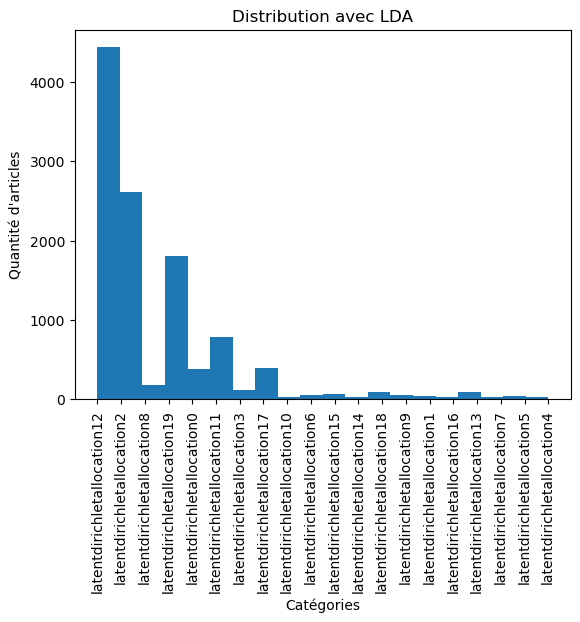

In [20]:
# plotting results distribution
plt.hist(maxindex, bins = 20)
plt.xlabel('Catégories')
plt.ylabel("Quantité d'articles")
plt.xticks(ticks=range(20), rotation = 90)
plt.title('Distribution avec LDA')

In [21]:
#function ripped from :
#https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
# for plotting topics in LDA
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

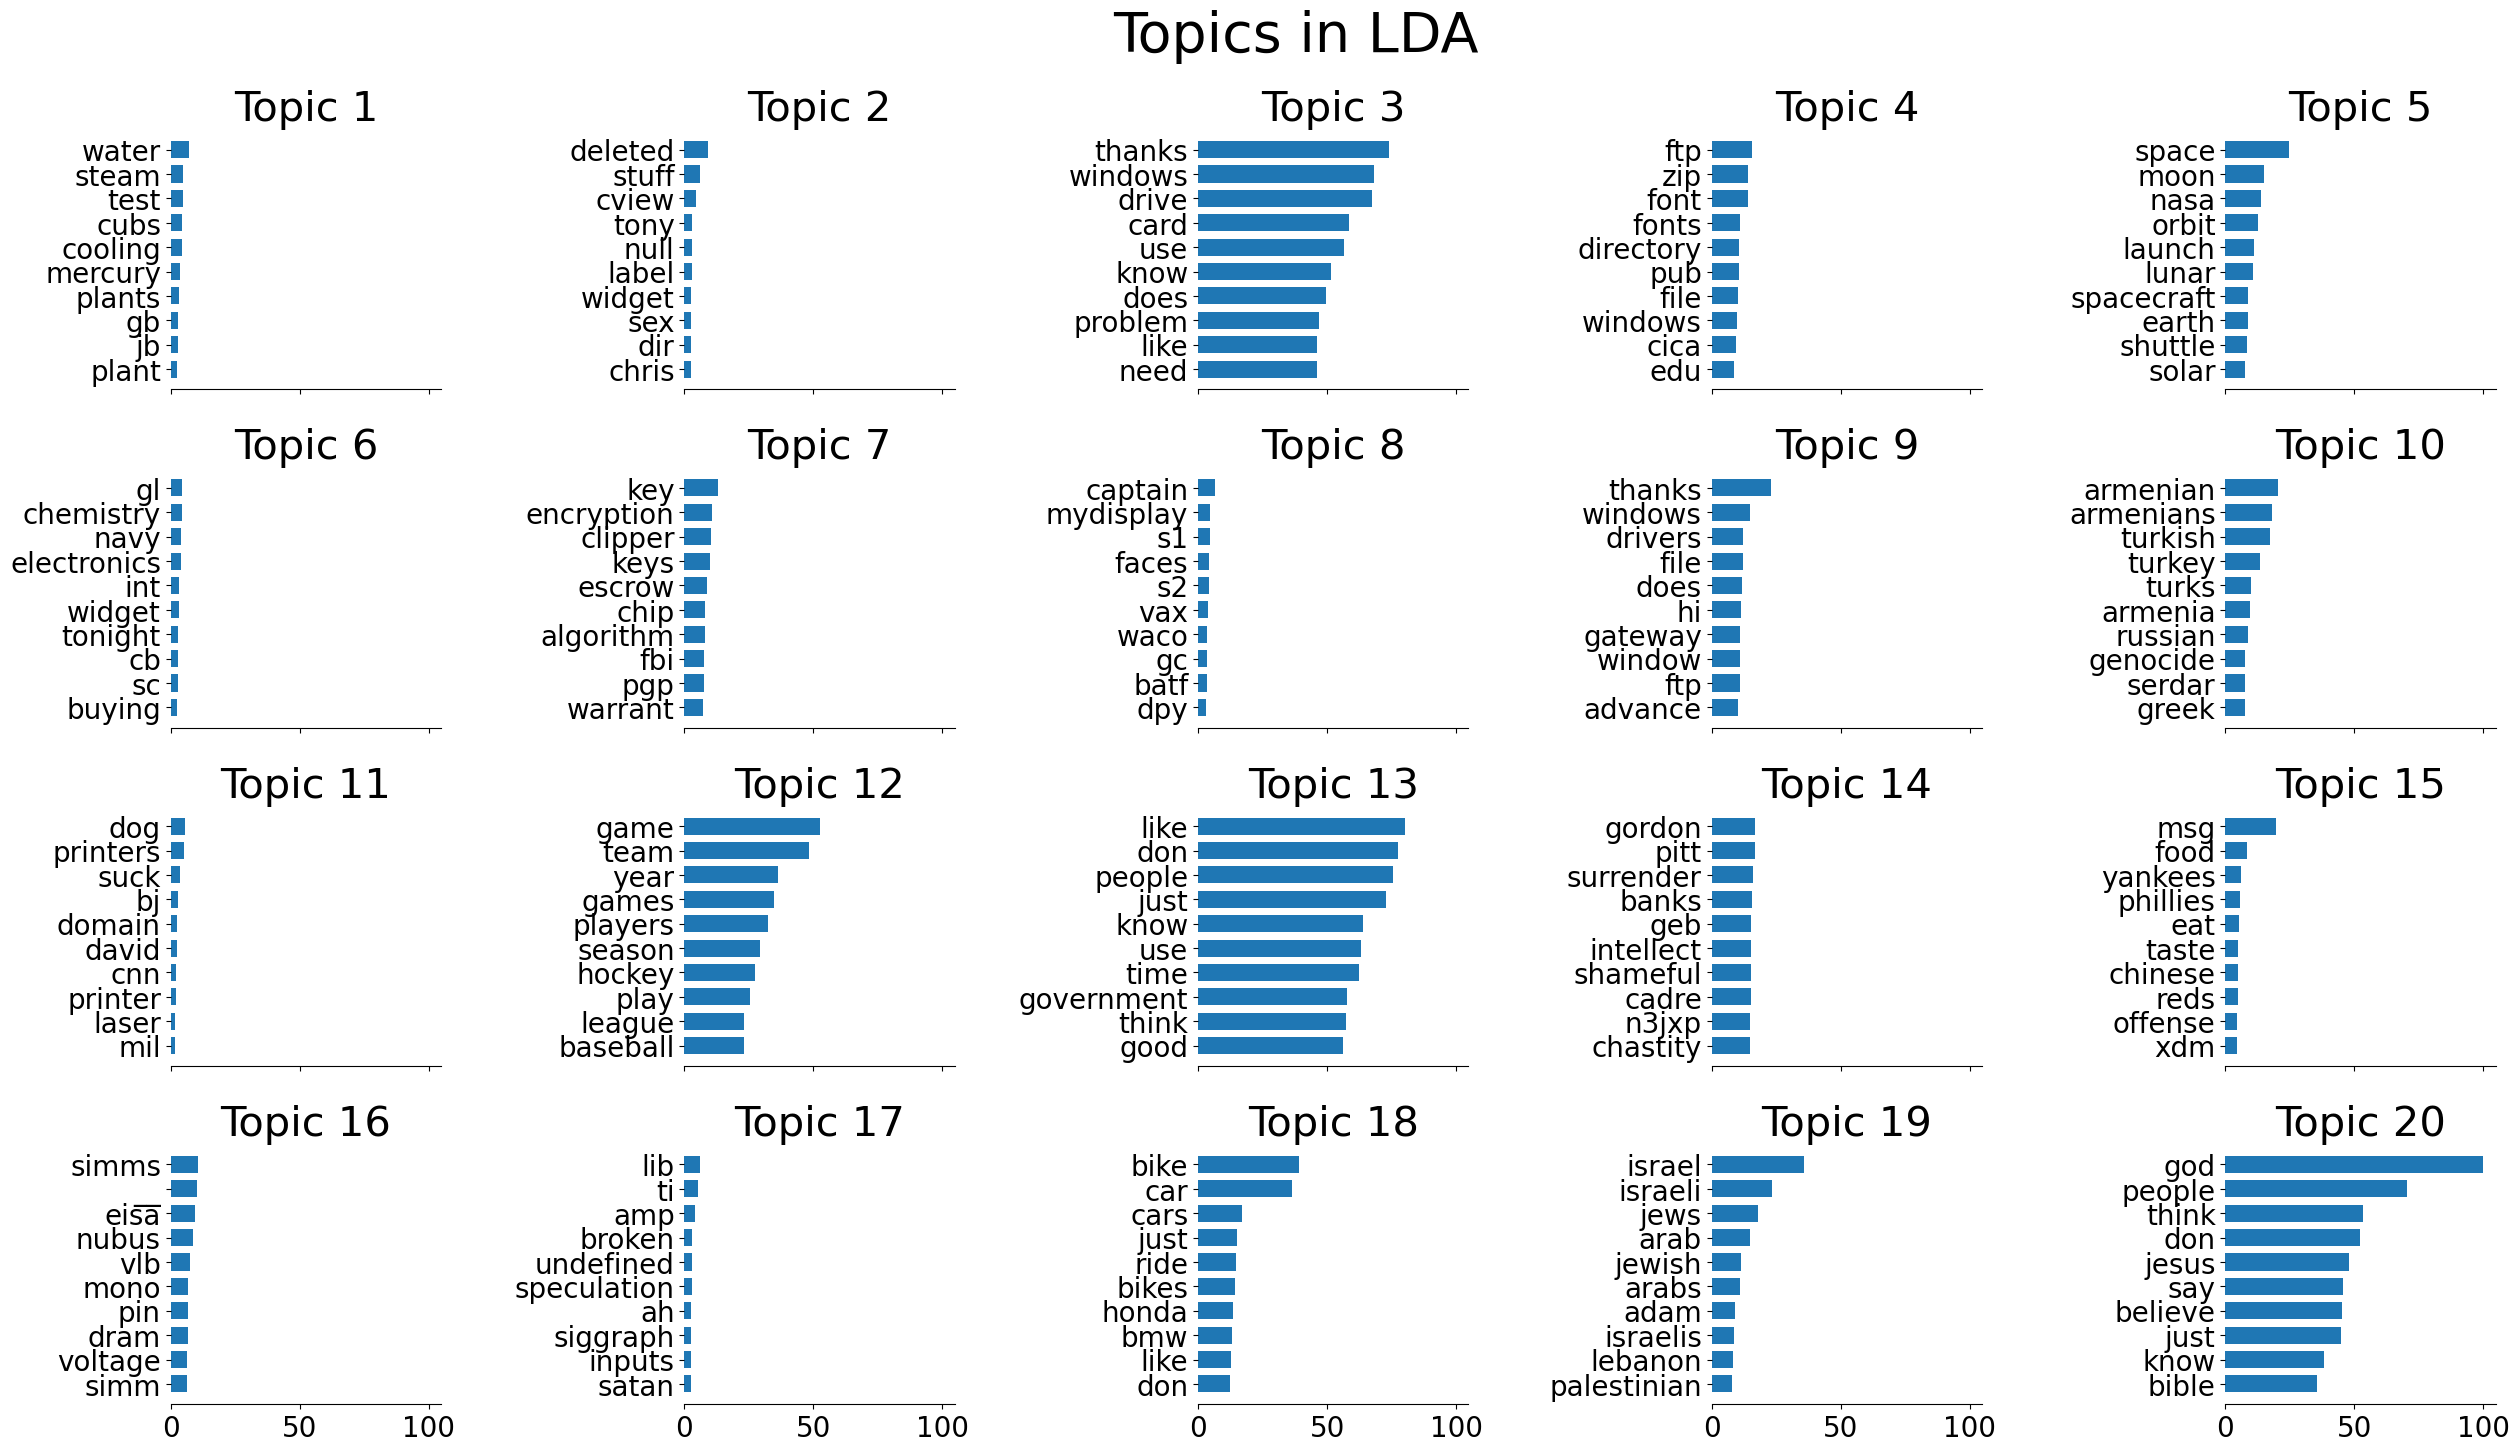

In [22]:
#extracting features from vectors and plotting topics
tf_feature_names = better_vec3.get_feature_names_out()
plot_top_words(LDA, tf_feature_names, 10, "Topics in LDA")

In [34]:
#At this point, i've done so many trials/errors and changes to the notebook, things stop to make sense. i should start over from scratch
#as i won't do that, let's try some classification for desert
# i'll reuse my trusting overcomplicated classification benchmark function, without gridsearch for this 
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score

dico_model = { 
    lgb.LGBMClassifier : {'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 8],
    'objective'

} }

def model_comp(x_train, x_test, y_train, y_test, modeldictionnary):
    ''' Function to compare different classification models and librairies
        
        input : 4 train/test splits : xtrain, xtest, ytrain, ytest
                modeldictionnary : dict containing model in sklearn object format as key, paramaters grid dict as values
                
        output: metrics dataframe, best estimators dict, confusion matrices dict'''

    #preformatting outputs
    output = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    estimators= dict()
    confusion = dict()

    #Extracting model
    for i, (model, param) in enumerate(modeldictionnary.items()):
        #declaring model 
        mod = model()

        #grid
        grid = GridSearchCV(mod, param, cv = 5, verbose= 2 , n_jobs=-1, refit= False)
        grid.fit(x_train, y_train)

        #Extracting Best Parameters
        best_params = grid.best_params_
        #fitting model with best parameters
        best_mod = model(**best_params)
        best_mod.fit(x_train, y_train)
        y_hat= best_mod.predict(x_test)


        #computing metrics
        accuracy = accuracy_score(y_test, y_hat)
        precision = precision_score(y_test, y_hat, average='macro')
        recall = recall_score(y_test, y_hat, average='macro')
        f1= f1_score(y_test, y_hat, average='macro')
        metrics = [accuracy, precision, recall, f1]
        
        #output format
        output.loc[mod.__class__.__name__] = metrics
        #saving best estimators in a dict
        estimators[mod.__class__.__name__] = best_mod
        #saving confusion matrix
        conf_matrix = confusion_matrix(y_test, y_hat)
        conf_matrix = conf_matrix/ conf_matrix.sum(axis = 1)
        confusion[mod.__class__.__name__] = conf_matrix
        #saving features importance

    return output.style.highlight_max(color='darkgrey'), estimators, confusion

better_vec4 = TfidfVectorizer(stop_words='english', max_features=1000)
x_train_vec4 = better_vec4.fit_transform(x_train)
x_test_vec4 = better_vec4.fit_transform(x_test)
sortie_df, best_estimators, conf_matr = model_comp(x_train_vec4, x_test_vec4, y_train, y_test, dico_model)
sortie_df

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [36]:
lgb_train = lgb.Dataset(x_train_vec4, y_train)
params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 20,
        'metric': 'multi_error',
        # 'num_leaves': 300,
        # 'min_data_in_leaf': 100,
        'learning_rate': 0.01,
        # 'feature_fraction': 0.8,
        # 'bagging_fraction': 0.8,
        # 'bagging_freq': 5,
        # 'lambda_l1': 0.4,
        # 'lambda_l2': 0.5,
        # 'min_gain_to_split': 0.2,
        # 'verbose': 5,
        # 'is_unbalance': True
    }
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                )

print('Start predicting...')

preds = gbm.predict(x_test_vec4, num_iteration=gbm.best_iteration) 
# output results
y_preds = []
for pred in preds:
    y_preds.append(int(np.argmax(pred)))
print(metrics.classification_report(y_test, y_preds))
# output feature importance
importance = gbm.feature_importance()
names = gbm.feature_name()

Start training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89519
[LightGBM] [Info] Number of data points in the train set: 11314, number of used features: 973
[LightGBM] [Info] Start training from score -3.160010
[LightGBM] [Info] Start training from score -2.963895
[LightGBM] [Info] Start training from score -2.951980
[LightGBM] [Info] Start training from score -2.953674
[LightGBM] [Info] Start training from score -2.974222
[LightGBM] [Info] Start training from score -2.948602
[LightGBM] [Info] Start training from score -2.962184
[LightGBM] [Info] Start training from score -2.946917
[LightGBM] [Info] Start training from score -2.940205
[LightGBM] [Info] Start training from score -2.941879
[LightGBM] [Info] Start training from score -2.936867
[LightGBM] [Info] Start training from score -2.945235
[LightGBM] [Info] Start training from sc

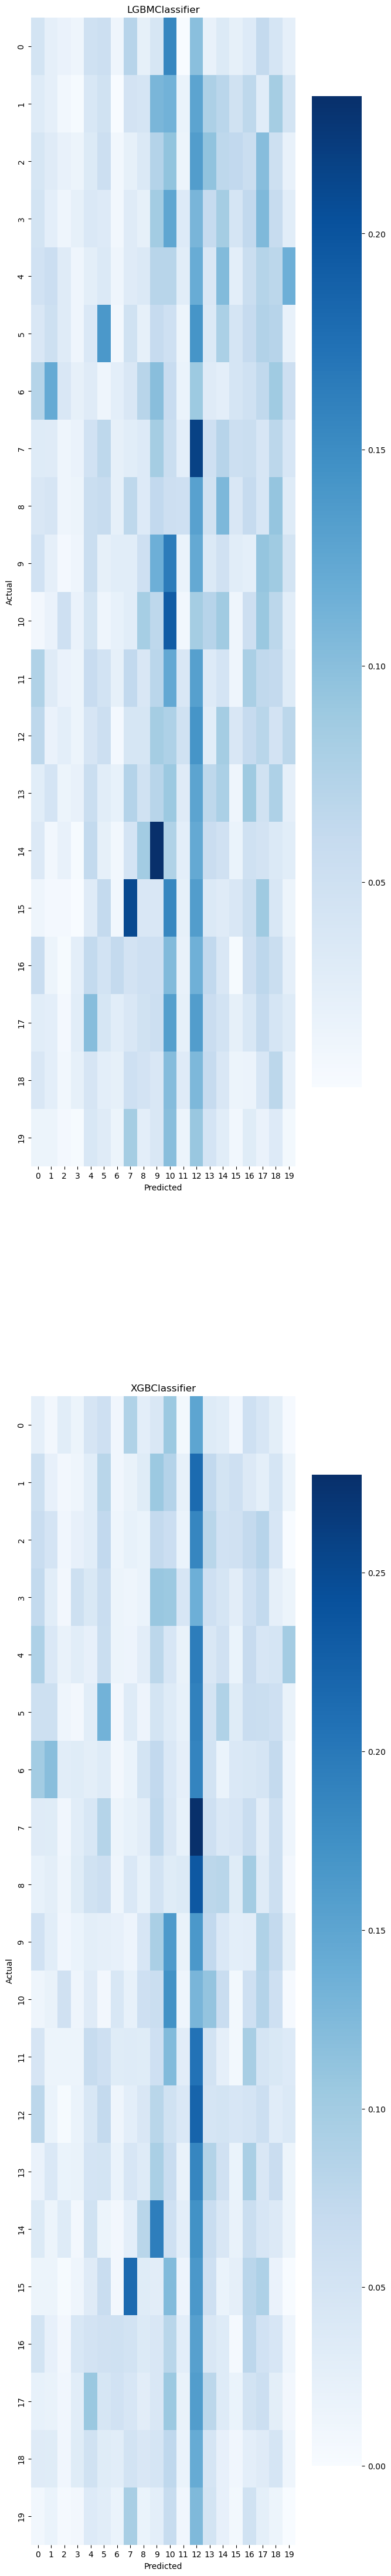

In [29]:
fig = plt.figure(figsize=(16,32))
my_grid = fig.add_gridspec(len(conf_matr), 1, 
                           #width_ratios = (1),
                            wspace = 0.2,
                            hspace = 0.2,
                           )

for i, (model, conf) in enumerate(conf_matr.items()):
    ax = fig.add_subplot(my_grid[i,0])
    sns.heatmap(conf, cmap='Blues', ax = ax)
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')